In [10]:
import math
import pandas as pd


from goatools.base import get_godag
from goatools.gosubdag.gosubdag import GoSubDag
from goatools.godag.go_tasks import get_go2parents, get_go2parents_isa
from goatools.obo_parser import GODag

godag = get_godag('go-basic.obo', optional_attrs="relationship")

# Modify here
num_readlines = math.inf

# Given Data
obsolete_GOs = ['GO:0046658', 'GO:0005779', 'GO:0015299', 'GO:0031305', 'GO:0030176', 'GO:0097056', 'GO:0099056', 'GO:0006471', 'GO:0008022', 'GO:0031225', 'GO:0140289', 'GO:0005639', 'GO:0046916', 'GO:0099055', 'GO:0030176']
clade_to_taxon = {'cellular organisms': 'cellular organisms', 'Eukaryota': 'Eukaryota', 'Opisthokonta': 'Eukaryota', 'Metazoa': 'Metazoa', 'Eumetazoa': 'Metazoa', 'Bilateria': 'Metazoa', 'Deuterostomia': 'Metazoa', 'Chordata': 'Chordata', 'Craniata': 'Chordata', 'Vertebrata': 'Chordata', 'Gnathostomata': 'Chordata', 'Teleostomi': 'Chordata', 'Euteleostomi': 'Chordata', 'Sarcopterygii': 'Chordata', 'Dipnotetrapodomorpha': 'Chordata', 'Tetrapoda': 'Chordata', 'Amniota': 'Chordata', 'Mammalia': 'Mammalia', 'Theria': 'Mammalia', 'Eutheria': 'Mammalia', 'Boreoeutheria': 'Mammalia', 'Euarchontoglires': 'Mammalia', 'Primates': 'Primates', 'Haplorrhini': 'Primates', 'Simiiformes': 'Primates', 'Catarrhini': 'Primates', 'Hominoidea': 'Primates', 'Hominidae': 'Hominidae', 'Homininae': 'Hominidae', 'Homo': 'Homo', 'Homo sapiens': 'Homo sapiens'}

fn = "clu-sap-repId_rankName_sapId_sapPlddt_sapGO.tsv"
f = open(f"../homo_sapiens/{fn}")

# internal
go_diversity = set()
go_frequency = {}

# output data
data = {'rank': [], 'GO_function': []}
pd_data = pd.DataFrame(columns = ['organism', 'rank', 'GO_function'])

n = 0
while True:
    line = f.readline().strip()
    n += 1
    
    if n >= num_readlines:
        break
    if not line:
        break
        
    tokens = line.split("\t")
    
    # organism_token = tokens[8]
    rank_token = tokens[1]
    go_token = tokens[4]
    
    if go_token in obsolete_GOs:
        continue
    
    taxon = clade_to_taxon[ rank_token ]
    
    data['rank'].append( taxon )
    data['GO_function'].append( f'{go_token}' )
    
    # generate internal data for analysis
    go_diversity.add( go_token )
    if not go_frequency.get( go_token ):
        go_frequency[ go_token ]=1
    else:
        go_frequency[ go_token ]+=1

f.close()
print(data)
pd_data = pd.DataFrame(data)
print(len(go_diversity))
print(len(data['rank']))

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-04-01) 46,575 Terms; optional_attrs(relationship)
{'rank': ['Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'Chordata', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'Mammalia', 'Mammalia', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukaryota', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'Hominidae', 'Hominidae', 'Hominidae', 'Hominidae', 'cellular organisms', 'cellular organisms', 'cellular organisms', 'Metazoa', 'Metazoa', 'Metazoa', 'Mammalia', 'Mammalia', 'Met

In [11]:
GO_function_table = pd_data.groupby(['rank', 'GO_function']).size().reset_index(name='counts')

In [12]:
rank_count_table = GO_function_table.pivot(index='GO_function', columns='rank', values='counts')
rank_count_table = rank_count_table.fillna(0)

In [13]:
taxon_order = ['cellular organisms', 'Eukaryota', 'Metazoa', 'Chordata', 'Mammalia', 'Primates', 'Hominidae', 'Homo sapiens']
rank_count_table = rank_count_table.reindex(columns=taxon_order)
rank_count_table = (rank_count_table.T / rank_count_table.T.sum()).T

In [14]:
GO_interest = """GO:0007156
GO:0140664
GO:0016874
GO:0004252
GO:0005815
GO:0005249
GO:0003777
GO:0006325
GO:0005096
GO:0016055
GO:0007229
GO:0043565
GO:0008083
GO:0003713
GO:0005179
GO:0006955
GO:0005634"""
selected_table = rank_count_table.loc[list(GO_interest.split())]

GO_interest_function = []
for GO in list(GO_interest.split()):
    GO_interest_function.append(godag[GO].name)
    
selected_table.index = GO_interest_function

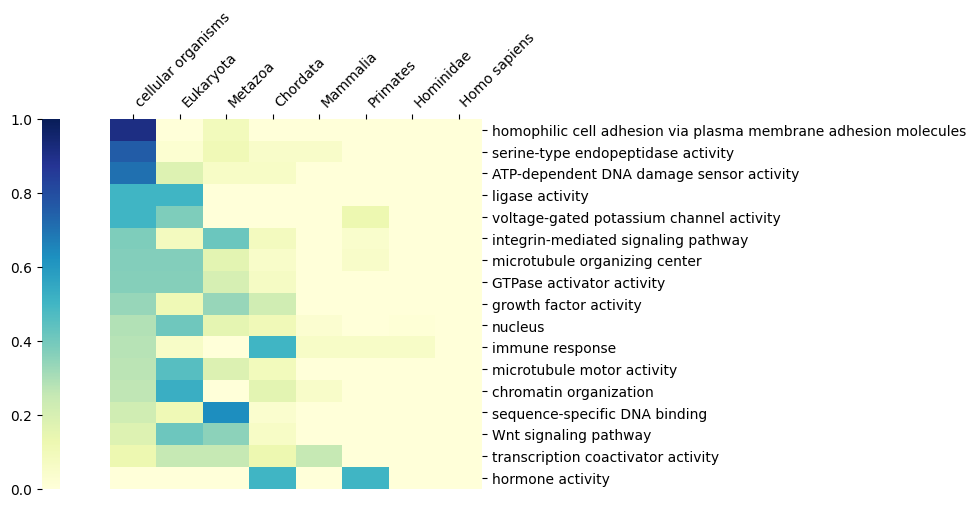

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


selected_table = selected_table.sort_values(by=taxon_order, ascending=False)
axr = sns.heatmap(selected_table, cmap='YlGnBu', xticklabels=True, yticklabels=True, fmt=".2g", vmax=1, \
           cbar_kws = dict(use_gridspec=False,location="left"))

axr.tick_params(labelleft=False, left=False, right=True, labelright=True,rotation=0)
axr.xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.ylabel('')
plt.xlabel('')
plt.savefig("result.svg")